# In-Class Kaggle Competition

## Rohan Nagar (ran679)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV

%matplotlib inline

/Users/rohannagar/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
def to_file(filename, ids, preds):
    with open(filename, 'w') as f:
        f.write('id,Y\n')
        for num, pred in zip(ids, preds):
            f.write('{},{}\n'.format(num, pred))

First, let's read in the data and check it out.

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [6]:
train.describe()

,id,Y,F1,F2,F3,F4,F5,F6,F7,F8,...,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27
count,49998.000000,49998.000000,49998.000000,49998.000000,49998.000000,49998.000000,48730.000000,4.999800e+04,49998.000000,49998.000000,...,49998.000000,40170.000000,49998.000000,49998.000000,49998.000000,49998.000000,49998.000000,49998.000000,49998.000000,49998.000000
mean,24999.500000,0.067223,1.043682,0.240510,5.272668,0.043542,0.753478,2.454196e+05,1.045302,1.041502,...,129.306232,6665.120065,1.045362,32.148846,8.446638,5.273124,1.043482,0.423617,52.306232,362.038515
std,14433.323716,0.250410,0.266339,4.161531,224.530270,0.256063,1.112498,3.915193e+07,0.281518,0.247753,...,14.797809,17780.169263,0.266208,3644.384303,5.121070,224.529521,0.259602,4.199845,14.797809,2212.369706
min,1.000000,0.000000,1.000000,0.000000,-0.372758,0.000000,0.000000,1.000000e+00,1.000000,1.000000,...,98.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,21.000000,0.000000
25%,12500.250000,0.000000,1.000000,0.000000,0.038775,0.000000,0.000000,1.000000e+00,1.000000,1.000000,...,118.000000,3400.000000,1.000000,0.000000,5.000000,0.030389,1.000000,0.000000,41.000000,0.176205
50%,24999.500000,0.000000,1.000000,0.000000,0.186073,0.000000,0.000000,2.000000e+00,1.000000,1.000000,...,129.000000,5362.000000,1.000000,0.000000,8.000000,0.154672,1.000000,0.000000,52.000000,0.366524
75%,37498.750000,0.000000,1.000000,0.000000,0.563830,0.000000,1.000000,9.000000e+00,1.000000,1.000000,...,140.000000,8200.000000,1.000000,1.000000,11.000000,0.555344,1.000000,0.000000,63.000000,0.875057
max,49998.000000,1.000000,18.000000,98.000000,29110.040580,8.000000,10.000000,8.194102e+09,23.000000,9.000000,...,184.000000,3008750.000000,10.000000,630367.000000,58.000000,29110.000000,10.000000,98.000000,107.000000,329664.000000


We have lots of features. Let's try to explore these a little more.

In [7]:
X_train = train.drop(['id', 'Y'], axis=1)
y_train = train['Y']

X_test = test.drop(['id'], axis=1)
ids = test['id']

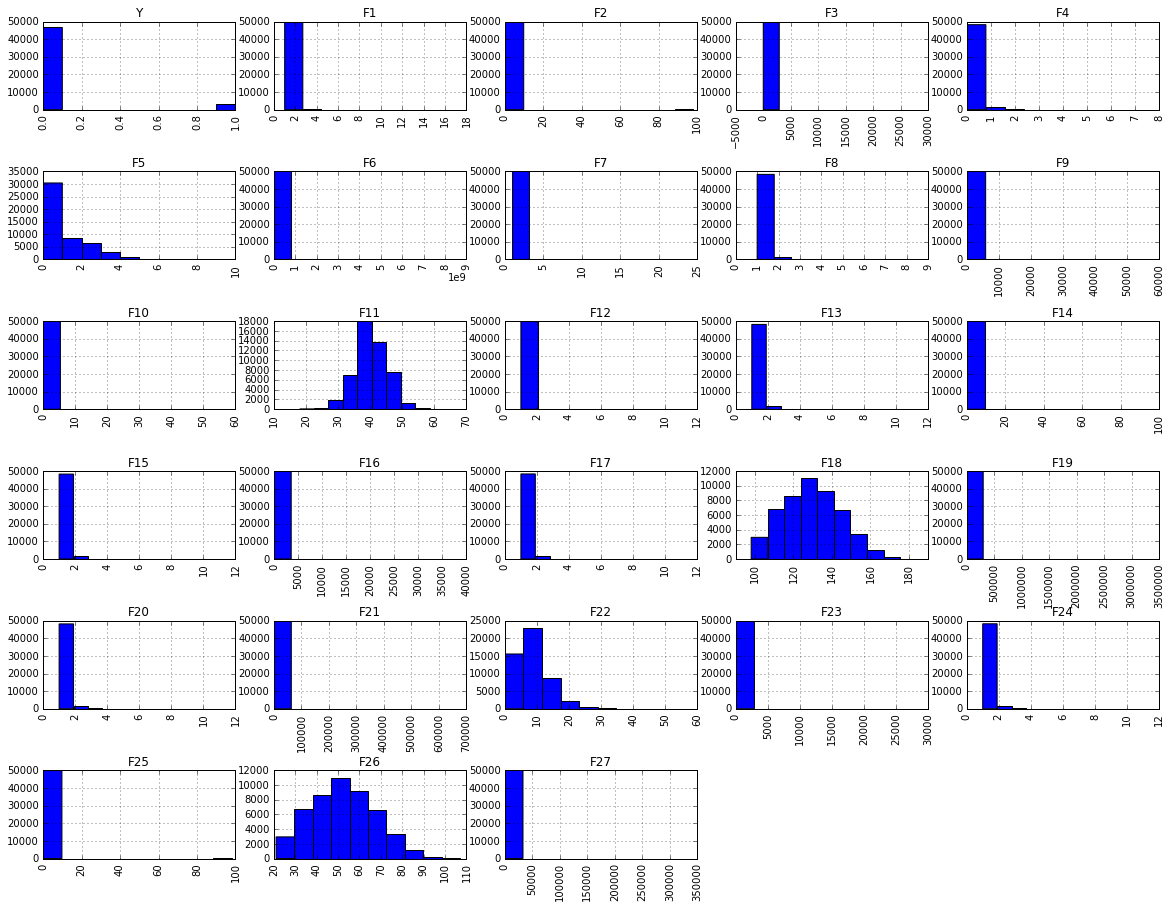

In [26]:
def show_feature_dist(df):
    """ Plot the distribution for each feature. """
    fig = plt.figure(figsize=(20, 15))
    cols = 5
    rows = np.ceil(float(df.shape[1]) / cols)
    for i, col in enumerate(df.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(col)
        if df.dtypes[col] == np.object:
            df[column].value_counts().plot(
                kind="bar", axes=ax)
        else:
            df[col].hist(axes=ax)
            plt.xticks(rotation="vertical")
    plt.subplots_adjust(hspace=0.7, wspace=0.2)
    plt.show()

show_feature_dist(train.drop('id', axis=1))

From this we can see that the classification problem for Y is lopsided. There are many more samples of class 0 than there are for class 1. We can also see that many of the features are not distributed very well. They tend to have many samples close together.

/Users/rohannagar/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


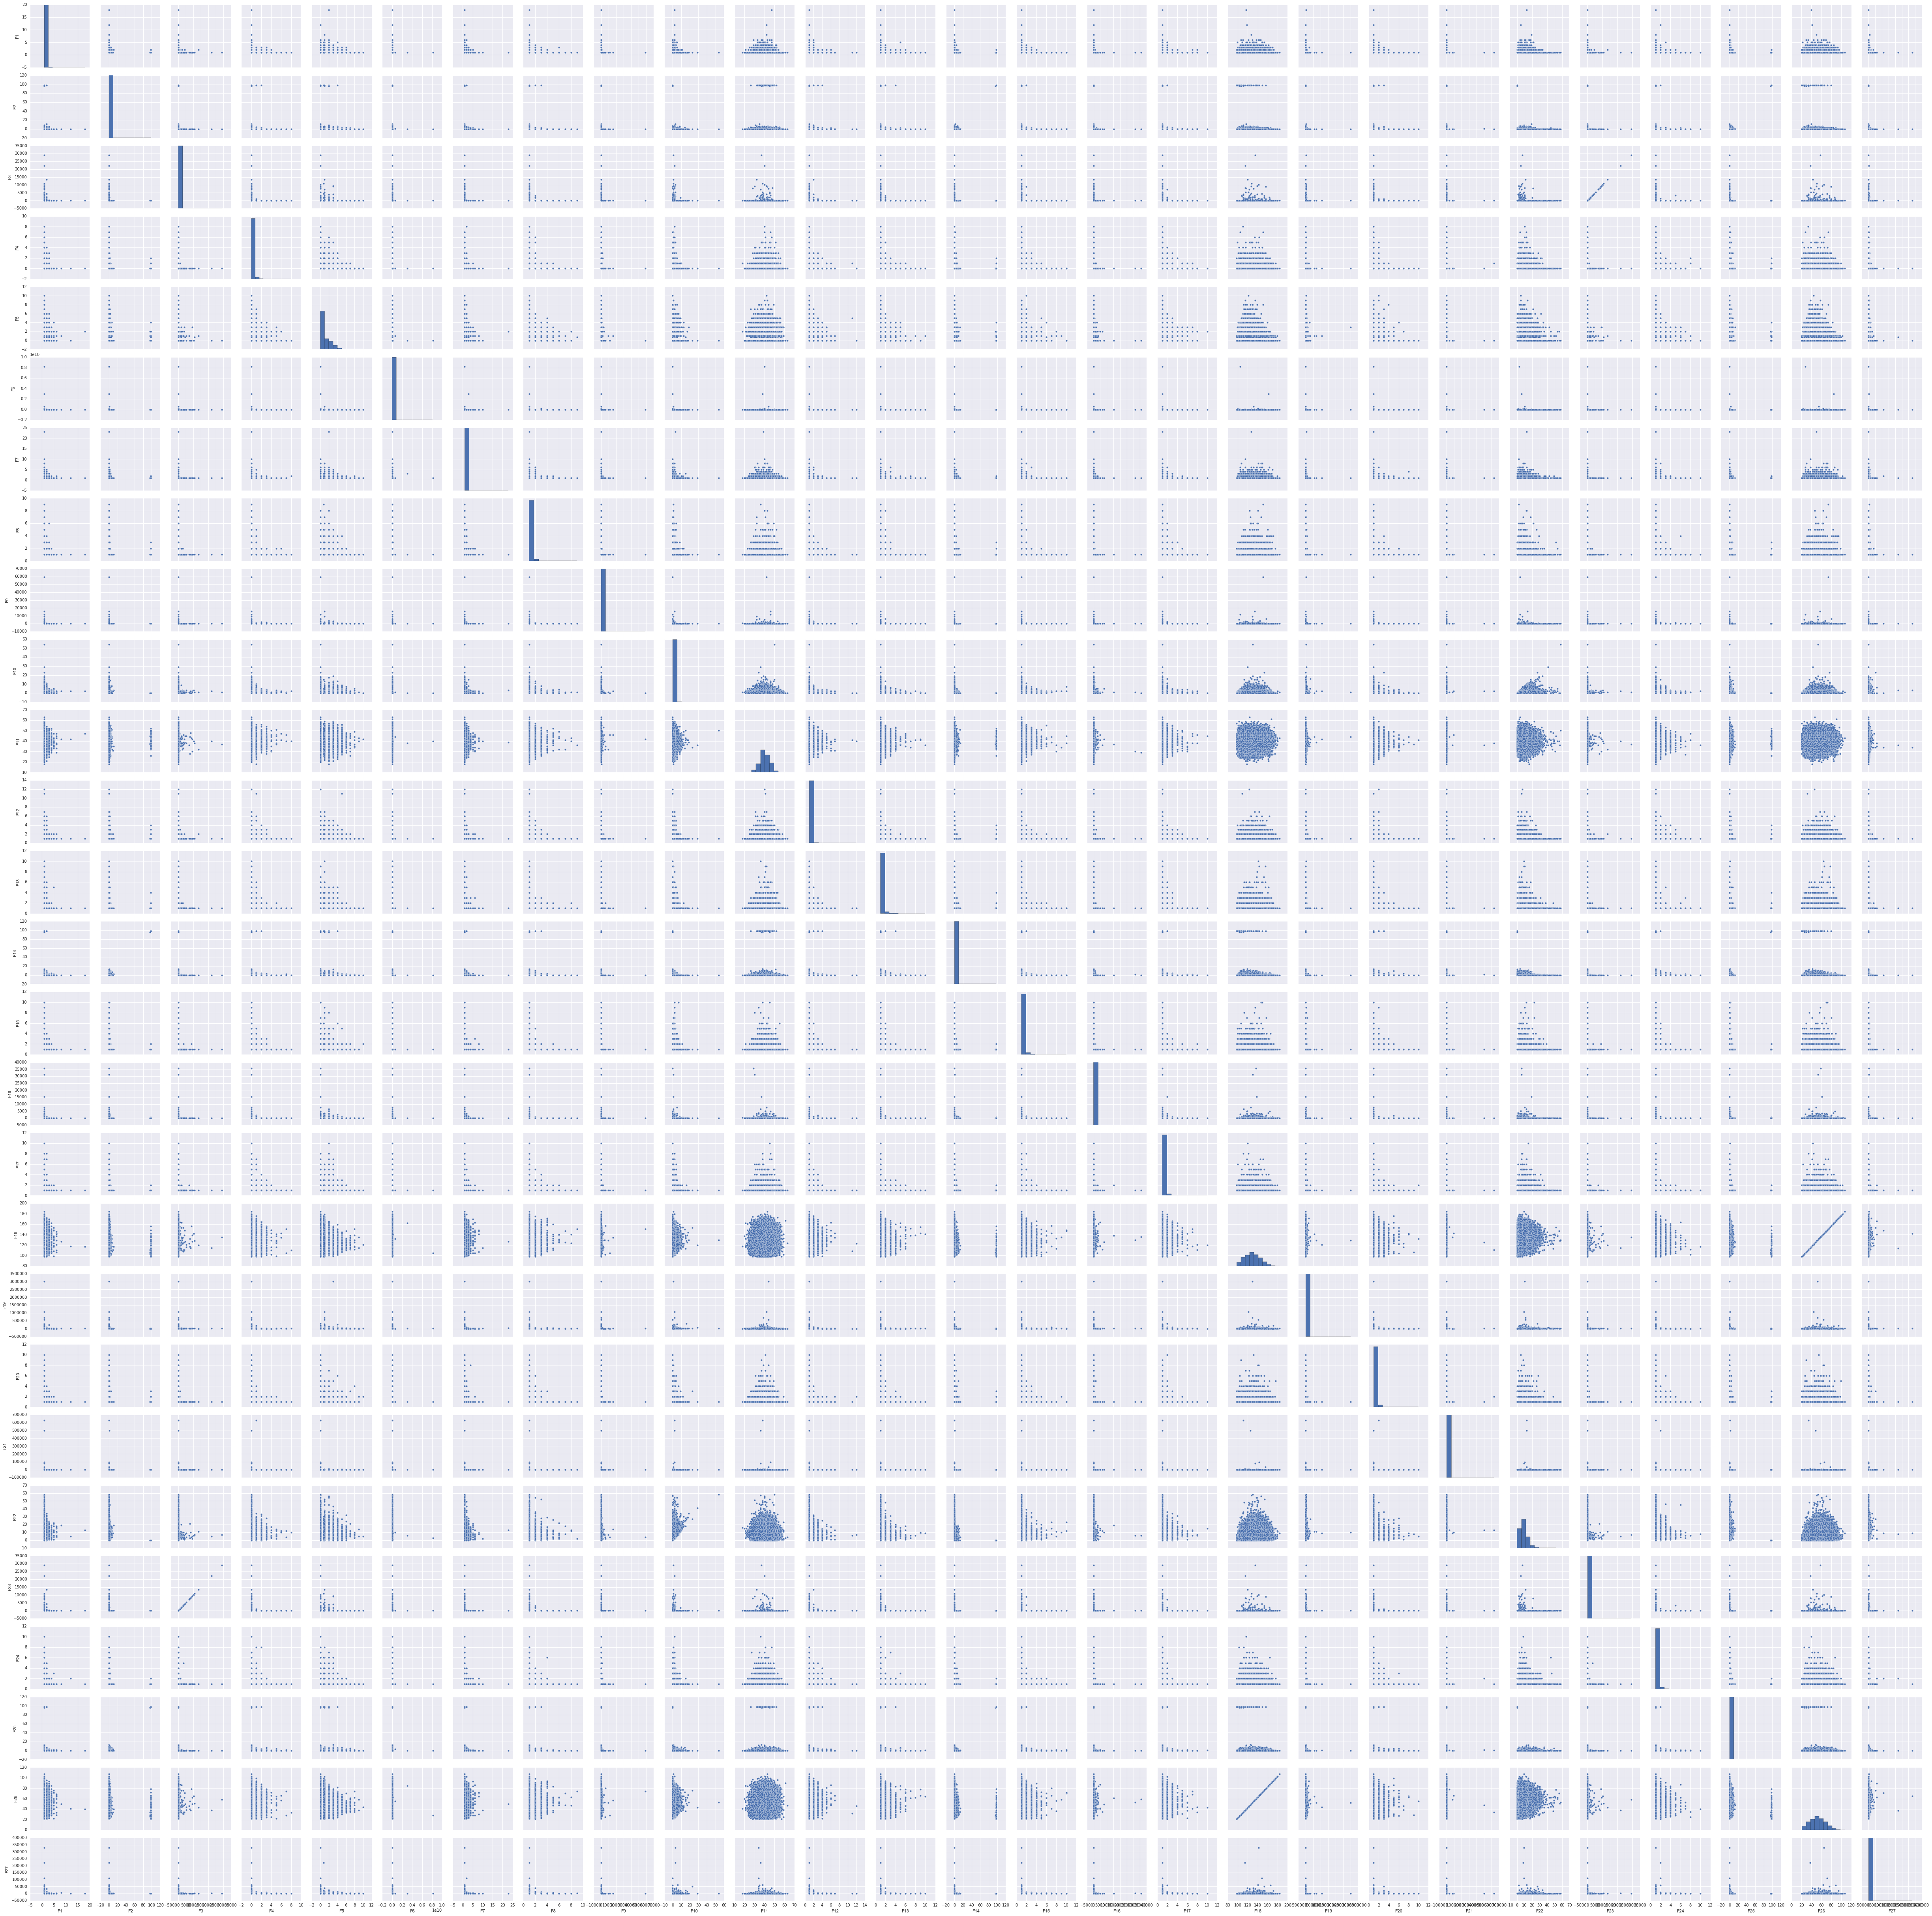

In [29]:
sns.pairplot(X_train)

From our pairplot, we can determine which features are highly correlated linearly. We can see that F18 and F26 are highly correlated, as well as F3 and F23. We can drop one from each pair to reduce our dimensionality.

In [9]:
# Fill NA values with the mean
train = train.fillna(train.mean())
test = test.fillna(train.mean())
train.describe()

,id,Y,F1,F2,F3,F4,F5,F6,F7,F8,...,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27
count,49998.000000,49998.000000,49998.000000,49998.000000,49998.000000,49998.000000,49998.000000,4.999800e+04,49998.000000,49998.000000,...,49998.000000,49998.000000,49998.000000,49998.000000,49998.000000,49998.000000,49998.000000,49998.000000,49998.000000,49998.000000
mean,24999.500000,0.067223,1.043682,0.240510,5.272668,0.043542,0.753478,2.454196e+05,1.045302,1.041502,...,129.306232,6665.120065,1.045362,32.148846,8.446638,5.273124,1.043482,0.423617,52.306232,362.038515
std,14433.323716,0.250410,0.266339,4.161531,224.530270,0.256063,1.098300,3.915193e+07,0.281518,0.247753,...,14.797809,15937.104788,0.266208,3644.384303,5.121070,224.529521,0.259602,4.199845,14.797809,2212.369706
min,1.000000,0.000000,1.000000,0.000000,-0.372758,0.000000,0.000000,1.000000e+00,1.000000,1.000000,...,98.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,21.000000,0.000000
25%,12500.250000,0.000000,1.000000,0.000000,0.038775,0.000000,0.000000,1.000000e+00,1.000000,1.000000,...,118.000000,3862.000000,1.000000,0.000000,5.000000,0.030389,1.000000,0.000000,41.000000,0.176205
50%,24999.500000,0.000000,1.000000,0.000000,0.186073,0.000000,0.000000,2.000000e+00,1.000000,1.000000,...,129.000000,6526.500000,1.000000,0.000000,8.000000,0.154672,1.000000,0.000000,52.000000,0.366524
75%,37498.750000,0.000000,1.000000,0.000000,0.563830,0.000000,1.000000,9.000000e+00,1.000000,1.000000,...,140.000000,7350.000000,1.000000,1.000000,11.000000,0.555344,1.000000,0.000000,63.000000,0.875057
max,49998.000000,1.000000,18.000000,98.000000,29110.040580,8.000000,10.000000,8.194102e+09,23.000000,9.000000,...,184.000000,3008750.000000,10.000000,630367.000000,58.000000,29110.000000,10.000000,98.000000,107.000000,329664.000000


In [11]:
X_train = train.drop(['id', 'Y'], axis=1)
y_train = train['Y']

X_test = test.drop(['id'], axis=1)
ids = test['id']

In [8]:
# Drop highly correlated features
X_train = X_train.drop(['F18', 'F3'], axis=1)
X_test = X_test.drop(['F18', 'F3'], axis=1)

## Model Testing

In [43]:
def print_cv_results(model):
    print("Best parameter set found:\n")
    print(model.best_params_)
    print()
    for params, mean_score, scores in model.grid_scores_:
        print("{0:.3f} (+/-{1:.03f}) for {2}".format(mean_score, scores.std() * 2, params))
    print()

### Logistic Regression

In [54]:
from sklearn.linear_model import LogisticRegression

params = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.05, 0.1],
}

regr = GridSearchCV(LogisticRegression(), params, cv=10, n_jobs=-1, scoring='roc_auc')
regr.fit(X_train, y_train)

print("Best parameter set found on development set with cv=10:\n")
print(regr.best_params_)
print()
for params, mean_score, scores in regr.grid_scores_:
    print("{0:.3f} (+/-{1:.03f}) for {2}".format(mean_score, scores.std() * 2, params))
print()

Best parameter set found on development set with cv=10:

{'C': 0.1, 'penalty': 'l1'}

0.649 (+/-0.034) for {'C': 0.001, 'penalty': 'l1'}
0.636 (+/-0.033) for {'C': 0.001, 'penalty': 'l2'}
0.686 (+/-0.028) for {'C': 0.01, 'penalty': 'l1'}
0.636 (+/-0.033) for {'C': 0.01, 'penalty': 'l2'}
0.688 (+/-0.030) for {'C': 0.05, 'penalty': 'l1'}
0.636 (+/-0.034) for {'C': 0.05, 'penalty': 'l2'}
0.692 (+/-0.023) for {'C': 0.1, 'penalty': 'l1'}
0.636 (+/-0.034) for {'C': 0.1, 'penalty': 'l2'}



/Users/rohannagar/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Our best score was 0.692, which is not very good. Let's train this model anyway so we can possibly use it in an ensemble later.

In [16]:
from sklearn.linear_model import LogisticRegression

regr = LogisticRegression(C=0.1, penalty='l1')
regr.fit(X_train, y_train)
preds = regr.predict_proba(X_test)[:, 1]
to_file('logistic_regression.csv', ids, preds)

### XGB

In [8]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

parameters = {
    'max_depth': [6, 7, 8],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200],
    'min_child_weight': [1/(0.05**(1/2)), 1/(0.95**(1/2))],
    'colsample_bytree': [0.4, 0.5]
}

xg_clf = RandomizedSearchCV(xgb.XGBClassifier(), parameters, n_iter=20, cv=10, n_jobs=-1, scoring='roc_auc')
xg_clf.fit(X_train, y_train)

print("Best parameter set found on development set with cv=10:\n")
print(xg_clf.best_params_)
print()
for params, mean_score, scores in xg_clf.grid_scores_:
    print("{0:.3f} (+/-{1:.03f}) for {2}".format(mean_score, scores.std() * 2, params))
print()

Best parameter set found on development set with cv=10:

{'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.4, 'min_child_weight': 4.47213595499958, 'n_estimators': 200}

0.859 (+/-0.017) for {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.4, 'min_child_weight': 4.47213595499958, 'n_estimators': 100}
0.856 (+/-0.018) for {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.4, 'min_child_weight': 4.47213595499958, 'n_estimators': 200}
0.858 (+/-0.018) for {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.4, 'min_child_weight': 1.0259783520851542, 'n_estimators': 100}
0.855 (+/-0.018) for {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.5, 'min_child_weight': 1.0259783520851542, 'n_estimators': 100}
0.860 (+/-0.018) for {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.5, 'min_child_weight': 4.47213595499958, 'n_estimators': 200}
0.859 (+/-0.016) for {'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.5, 'min_ch

/Users/rohannagar/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Here we did much better. 0.860 was our best score! Let's train this one.

In [9]:
xg = xgb.XGBClassifier(max_depth=8, learning_rate=0.3, n_estimators=155, min_child_weight=0.6, subsample=1.0, colsample_bytree=0.45)
xg.fit(X_train, y_train)
preds = xg.predict_proba(X_test)[:, 1]
to_file('xgb.csv', ids, preds)

In [10]:
# POST-DEADLINE

import xgboost as xgb

xg = xgb.XGBClassifier(max_depth=4, learning_rate=0.01, n_estimators=1000)
xg.fit(X_train, y_train)
preds = xg.predict_proba(X_test)[:, 1]
to_file('xgb_new.csv', ids, preds)

/Users/rohannagar/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Random Forest

This one actually does quite well with the parameters already set as shown.

In [7]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=2000, criterion='entropy', max_features='auto', bootstrap=True)
rf.fit(X_train, y_train)
preds = rf.predict_proba(X_test)[:, 1]
to_file('random_forest.csv', ids, preds)

### AdaBoost

In [59]:
from sklearn.ensemble import AdaBoostClassifier

param_grid = [
    {'n_estimators': [1000],
     'learning_rate': [0.1, 1],
    },
]

cv = 10
ab_clf = GridSearchCV(AdaBoostClassifier(),
                   param_grid=param_grid, cv=cv, n_jobs=-1, scoring='roc_auc')
ab_clf.fit(X_train, y_train)

print_cv_results(ab_clf)

Best parameter set found:

{'n_estimators': 1000, 'learning_rate': 0.1}

0.855 (+/-0.021) for {'n_estimators': 1000, 'learning_rate': 0.1}
0.840 (+/-0.024) for {'n_estimators': 1000, 'learning_rate': 1}



/Users/rohannagar/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


AdaBoost does well too!

In [15]:
from sklearn.ensemble import AdaBoostClassifier

ab = AdaBoostClassifier(n_estimators=1000, learning_rate=0.1)
ab.fit(X_train, y_train)
preds = ab.predict_proba(X_test)[:, 1]
to_file('adaboost.csv', ids, preds)

### K-Nearest Neighbors

In [11]:
from sklearn.neighbors import KNeighborsClassifier

params = {
    'n_neighbors': [500, 750, 1000],
    'weights': ['distance']
}

knn = GridSearchCV(KNeighborsClassifier(), param_grid=params, cv=10, n_jobs=-1, scoring='roc_auc')
knn.fit(X_train, y_train)

print_cv_results(knn)

Best parameter set found:

{'n_neighbors': 500, 'weights': 'distance'}

0.615 (+/-0.038) for {'n_neighbors': 500, 'weights': 'distance'}
0.612 (+/-0.042) for {'n_neighbors': 750, 'weights': 'distance'}
0.611 (+/-0.042) for {'n_neighbors': 1000, 'weights': 'distance'}



/Users/rohannagar/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


KNN didn't do so well, along the same lines as logistic regression.

### Naive Bayes

In [17]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

gnb = GaussianNB()
score = cross_val_score(gnb, X=X_train, y=y_train, scoring='roc_auc', cv=15, n_jobs=-1)
print(score)
print(score.mean())

[ 0.50001143  0.5061122   0.51623455  0.54630709  0.56975141  0.52200409
  0.49054588  0.50741798  0.53882593  0.49631686  0.50011775  0.5377016
  0.50313965  0.49719277  0.53224797]
0.517595143588


Naive Bayes definitely didn't do well on our dataset. There are not really any parameters to adjust with this model, so this is the best we can get.

### Tensor Flow Neural Net

In [11]:
import skflow
from sklearn.model_selection import cross_val_score

classifier = skflow.TensorFlowDNNClassifier(hidden_units=[5], n_classes=2, steps=50000, learning_rate=0.05)
# classifier.fit(X_train, y_train)
# score = accuracy_score(classifier.predict(indep_test), dep_test)
# print("Accuracy: %f" % score)
score = cross_val_score(classifier, X=X_train, y=y_train, scoring='roc_auc', cv=10, n_jobs=-1)
print(score)
print(score.mean())

[ 0.50192967  0.50130687  0.50033214  0.50150086  0.50160806  0.50171527
  0.50182247  0.50160841  0.49990298  0.49979608]
0.501152280851
Step #1, avg. loss: 1324.83167
Step #1, avg. loss: 1435.33801
Step #1, avg. loss: 1452.96289
Step #1, avg. loss: 1376.14307
Step #5001, epoch #3, avg. loss: 0.42124Step #5001, epoch #3, avg. loss: 82.00351Step #5001, epoch #3, avg. loss: 8.12468Step #5001, epoch #3, avg. loss: 5.07146



Step #10001, epoch #7, avg. loss: 0.25577Step #10001, epoch #7, avg. loss: 0.24530Step #10001, epoch #7, avg. loss: 0.24688Step #10001, epoch #7, avg. loss: 0.24686



Step #15001, epoch #10, avg. loss: 0.24665Step #15001, epoch #10, avg. loss: 0.24667Step #15001, epoch #10, avg. loss: 0.24670Step #15001, epoch #10, avg. loss: 0.24668



Step #20001, epoch #14, avg. loss: 0.24614Step #20001, epoch #14, avg. loss: 0.24604Step #20001, epoch #14, avg. loss: 0.24667Step #20001, epoch #14, avg. loss: 0.24629



Step #25001, epoch #17, avg. loss: 0.24644Step #25001, epoch 

/Users/rohannagar/anaconda/lib/python3.5/site-packages/skflow/io/data_feeder.py:217: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  out.itemset((i, self.y[sample]), 1.0)
/Users/rohannagar/anaconda/lib/python3.5/site-packages/skflow/io/data_feeder.py:217: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  out.itemset((i, self.y[sample]), 1.0)
/Users/rohannagar/anaconda/lib/python3.5/site-packages/skflow/io/data_feeder.py:217: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  out.itemset((i, self.y[sample]), 1.0)
/Users/rohannagar/anaconda/lib/python3.5/site-packages/skflow/io/data_feeder.py:217: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  out.itemset((i, self.y[sample]), 1.0)


In [13]:
classifier = skflow.TensorFlowDNNClassifier(hidden_units=[5, 3, 4], n_classes=2, steps=50000, learning_rate=0.05)
classifier.fit(X_train, y_train)
preds = classifier.predict_proba(X_test)[:, 1]
to_file('tnn2.csv', ids, preds)

Step #1, avg. loss: 21.75230
Step #5001, epoch #3, avg. loss: 0.33075
Step #10001, epoch #6, avg. loss: 0.24657
Step #15001, epoch #9, avg. loss: 0.24605
Step #20001, epoch #12, avg. loss: 0.24647
Step #25001, epoch #15, avg. loss: 0.25024
Step #30001, epoch #19, avg. loss: 0.24674
Step #35001, epoch #22, avg. loss: 0.24712
Step #40001, epoch #25, avg. loss: 0.24585
Step #45001, epoch #28, avg. loss: 0.24632


/Users/rohannagar/anaconda/lib/python3.5/site-packages/skflow/io/data_feeder.py:217: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  out.itemset((i, self.y[sample]), 1.0)


## Ensembling

### Ranked Average

Ranked average should be a good way to ensemble the results we've been getting from our previous models. Looking at the Kaggle forums here https://www.kaggle.com/c/predict-west-nile-virus/forums/t/14381/combine-models-result/81209, I was able to use code that people had described in the forums for rank-averaging.

See also: http://mlwave.com/kaggle-ensembling-guide/

Basically you rank the outputs, average the ranks, and then scale the ranks for the final result.

In [58]:
from collections import defaultdict

def rank_avg(files, outfile):
    with open(outfile, 'w') as out:
        ranks = defaultdict(list)
        for i, f in enumerate(files):
            file_ranks = []

            lines = open(f).readlines()
            lines = [lines[0]] + sorted(lines[1:])
            for e, line in enumerate(lines):
                if e > 0:
                    r = line.strip().split(",")
                    file_ranks.append((float(r[1]), e, r[0]))

            for rank, item in enumerate(sorted(file_ranks)):
                ranks[(item[1],item[2])].append(rank)

        average_ranks = []
        for k in sorted(ranks):
            average_ranks.append((sum(ranks[k])/len(ranks[k]), k))

        ranked_ranks = []
        for rank, k in enumerate(sorted(average_ranks)):
            ranked_ranks.append((k[1][0], k[1][1], rank/(len(average_ranks) - 1)))

        out.write('id,Y\n')
        for k in sorted(ranked_ranks):
            out.write('{},{}\n'.format(k[1], k[2]))

In [ ]:
files = ['logistic_regression.csv', # Logistic Regression
         'xgb.csv', # XGBoost
         'random_forest.csv', # Random Forest
         'adaboost.csv', # AdaBoost
        ]
    
outfile = 'ranked_avg.csv'
rank_avg(files, outfile)

### Stacking

In [57]:
# Use logistic regression as a feature
preds = regr.predict_proba(X_train)[:, 1]
X_train_lg = X_train
X_train_lg['lg'] = preds

preds = regr.predict_proba(X_test)[:, 1]
X_test_lg = X_test
X_test_lg['lg'] = preds

In [45]:
# Train AdaBoost
ab = AdaBoostClassifier(n_estimators=1000, learning_rate=0.1)
ab.fit(X_train_lg, y_train)

In [58]:
# Use AdaBoost as feature
preds = ab.predict_proba(X_train_lg)[:, 1]
X_train_lg_ab = X_train_lg
X_train_lg_ab['ab'] = preds

preds = ab.predict_proba(X_test_lg)[:, 1]
X_test_lg_ab = X_test_lg
X_test_lg_ab['ab'] = preds

In [60]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf = RandomForestClassifier(n_estimators=2000, criterion='entropy', max_features='auto', bootstrap=True)
rf.fit(X_train_lg_ab, y_train)
preds = rf.predict_proba(X_test_lg_ab)[:, 1]
to_file('logistic_adaboost_randomforest.csv', ids, preds)

In [61]:
# Use RF as feature
preds = rf.predict_proba(X_train_lg_ab)[:, 1]
X_train_lg_ab_rf = X_train_lg_ab
X_train_lg_ab_rf['rf'] = preds

preds = rf.predict_proba(X_test_lg_ab)[:, 1]
X_test_lg_ab_rf = X_test_lg_ab
X_test_lg_ab_rf['rf'] = preds

In [63]:
import xgboost as xgb

# Train XGB
xg = xgb.XGBClassifier(max_depth=8, learning_rate=0.3, n_estimators=155, min_child_weight=0.6, subsample=1.0, colsample_bytree=0.45)
xg.fit(X_train_lg_ab_rf, y_train)
preds = xg.predict_proba(X_test_lg_ab_rf)[:, 1]
to_file('logistic_adaboost_randomforest_xgb.csv', ids, preds)

### Try a different order

In [72]:
# Use logistic regression as a feature
preds = regr.predict_proba(X_train)[:, 1]
X_train_lg = X_train
X_train_lg['lg'] = preds

preds = regr.predict_proba(X_test)[:, 1]
X_test_lg = X_test
X_test_lg['lg'] = preds

In [73]:
# Train XGB
xg = xgb.XGBClassifier(max_depth=8, learning_rate=0.3, n_estimators=155, min_child_weight=0.6, subsample=1.0, colsample_bytree=0.45)
xg.fit(X_train_lg, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.45,
       gamma=0, learning_rate=0.3, max_delta_step=0, max_depth=8,
       min_child_weight=0.6, missing=None, n_estimators=155, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1.0)

In [74]:
# Use XGB as feature
preds = xg.predict_proba(X_train_lg)[:, 1]
X_train_lg_xg = X_train_lg
X_train_lg_xg['xg'] = preds

preds = xg.predict_proba(X_test_lg)[:, 1]
X_test_lg_xg = X_test_lg
X_test_lg_xg['xg'] = preds

In [75]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=2000, criterion='entropy', max_features='auto', bootstrap=True)
rf.fit(X_train_lg_xg, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=2000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [76]:
# Use RF as feature
preds = rf.predict_proba(X_train_lg_xg)[:, 1]
X_train_lg_xg_rf = X_train_lg_xg
X_train_lg_xg_rf['rf'] = preds

preds = rf.predict_proba(X_test_lg_xg)[:, 1]
X_test_lg_xg_rf = X_test_lg_xg
X_test_lg_xg_rf['rf'] = preds

In [78]:
# Train AdaBoost
ab = AdaBoostClassifier(n_estimators=1000, learning_rate=0.1)
ab.fit(X_train_lg_xg_rf, y_train)
preds = ab.predict_proba(X_test_lg_xg_rf)[:, 1]
to_file('logistic_xgb_randomforest_adaboost.csv', ids, preds)

In [ ]:
class StackedEnsemble():
    
    def __init__(self):
        self.logistic_regr = LogisticRegression(C=0.1, penalty='l1')
        self.adaboost = AdaBoostClassifier(n_estimators=1000, learning_rate=0.1)
        self.random_forest = RandomForestClassifier(n_estimators=2000, criterion='entropy', max_features='auto', bootstrap=True)
        self.xgb = xgb.XGBClassifier(max_depth=4, learning_rate=0.01, n_estimators=1000)
        
        
    def fit(self, X, y):
        self.logistic_regr.fit(X, y)
        preds = self.logistic_regr.predict_proba(X)[:, 1]
        X = add_feature(X, 'lg', preds)

        self.adaboost.fit(X, y)
        preds = self.adaboost.predict_proba(X)[:, 1]
        X = add_feature(X, 'ab', preds)
        
        self.random_forest.fit(X, y)
        preds = self.random_forest.predict_proba(X)[:, 1]
        X = add_feature(X, 'rf', preds)
        
        self.xgb.fit(X, y)
        
        
    def predict_proba(self, X_test):
        preds = self.logistic_regr.predict_proba(X_test)[:, 1]
        X_test = add_feature(X_test, 'lg', preds)
        
        preds = self.adaboost.predict_proba(X_test)[:, 1]
        X_test = add_feature(X_test, 'ab', preds)
        
        preds = self.random_forest.predict_proba(X_test)[:, 1]
        X_test = add_feature(X_test, 'rf', preds)
        
        return self.xgb.predict_proba(X_test)[:, 1]
        
        
    def add_feature(X, name, values):
        X_new = X
        X_new[name] = values
        
        return X_new